In [1]:
# Data handling and computation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Model selection and validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Pipeline library for efficient workflow
from sklearn.pipeline import Pipeline, make_pipeline

# Metrics libraries for evaluating model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, roc_curve, auc, accuracy_score, confusion_matrix, precision_score
from sklearn import metrics

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


In [2]:
# Read in data locally
#df = pd.read_csv('data/Tweets.csv', encoding='latin1')

# Read in data using google colab/drive
df = pd.read_csv('/content/drive/MyDrive/Flatiron/project_4/tweets.csv', encoding='latin1')

In [3]:
numerical_features = list(df.select_dtypes("number"))
categorical_features = list(df.select_dtypes("object"))

print(f'Numerical Columns: \n{numerical_features}\n')
print(f'Categorical Columns: \n{categorical_features}')

Numerical Columns: 
[]

Categorical Columns: 
['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']


## EDA

In [4]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
df.nunique().sort_values(ascending=True)

is_there_an_emotion_directed_at_a_brand_or_product       4
emotion_in_tweet_is_directed_at                          9
tweet_text                                            9065
dtype: int64

In [7]:
df.isna().sum().sort_values(ascending=False)

emotion_in_tweet_is_directed_at                       5802
tweet_text                                               1
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [8]:
df.corr()

<ipython-input-8-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


""



## Data Cleaning

In [9]:
# Lowercase
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# Renaming columns to better reflect the data
rename_cols = {
      'tweet_text': 'tweet',
      'emotion_in_tweet_is_directed_at': 'tweet_is_directed_at',
      'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
              }
df = df.rename(columns=rename_cols)


# rename values in the 'emotion' column
rename_values = {
      'no emotion toward brand or product': 'no emotion',
      'positive emotion': 'positive',
      'negative emotion': 'negative',
      "i can't tell": 'unsure'
              }
df['emotion'] = df['emotion'].map(rename_values)


# Dropping (1) single row from df['tweet_text']
df.dropna(subset=['tweet'], inplace=True)


# Filter out 17 tweets that contain both Apple & Google
apple_and_google = ~((df['tweet_is_directed_at'].isna()) &
                   (df['tweet'].str.contains('google')) &
                   (df['tweet'].str.contains('apple')))
df = df[apple_and_google]



## Create assert statements to confirm the code achieved its goals:

assert df.loc[(df['tweet_is_directed_at'].isna()) & (df['tweet'].str.contains('google')) & (df['tweet'].str.contains('apple')), 'tweet'].empty


## Feature Engineering

In [10]:
# Create column of with the character length of the tweet
df['character_count'] = df['tweet'].apply(len)


# Create column of with the word count of the tweet
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))


# Creat column to determine if the tweet was negative toward a brand or not
df['is_tweet_negative'] = df['emotion'].apply(lambda x: 1 if x == 'negative' else 0 if x == 'positive' else 2)

# What company is the tweet about?
renamed_values = {
      'ipad': 1, 'ipad or iphone app': 1,
      'iphone': 1, 'other google product or service': 0,
      'android app': 0, 'android': 0, 'google': 0,
      'other apple product or service': 1, 'apple': 1
                 }
df['is_apple'] = df['tweet_is_directed_at'].map(renamed_values).astype('Int64')


# Creating a feature call 'number_of_mentions' to count @mentions
df['number_of_mentions'] = df['tweet'].str.count('@\w+')


# Create a feature 'hashtags_count' to count hashtags
df['hashtags_count'] = df['tweet'].str.count('#')


# Create feature named 'average_word_length'
df['average_word_length'] = df['tweet'].apply(lambda x: np.mean([len(word) for word in x.split()]))

# Adding column to tell if data was generated by chatgpt data
df['chatgpt_data'] = 0


## Data Filtering

In [11]:
# Assigning unknown tweet to company based on 'apple_words'
apple_words = ['apple', 'iphone','ipod','ipad', 'i-pad', 'app store', 'itunes']
apple_regex = '|'.join(apple_words)  # creates the string 'apple|iphone|ipod|ipad|i-pad'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(apple_regex, case=False), 'is_apple'] = 1


# Assigning unknown tweet to company based on 'google_words'
google_words = ['google', 'android','pixel', 'google play']
google_regex = '|'.join(google_words)  # creates the string 'google|android|pixel|google play'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(google_regex, case=False), 'is_apple'] = 0


# Dropping tweets that have no mention of either Apple or Google
df.dropna(subset=['is_apple'], inplace=True)


# Drop the column 'tweet_is_directed_at' due to many missing values
#df = df.drop(columns=['tweet_is_directed_at'])

In [12]:
df['is_tweet_negative'].value_counts()

2    4833
0    2967
1     569
Name: is_tweet_negative, dtype: int64

## Import and Join Negative Tweet Data (via ChatGPT prompt engineering)

In [13]:
df['is_tweet_negative'].value_counts()

2    4833
0    2967
1     569
Name: is_tweet_negative, dtype: int64

In [14]:
# Read in data locally
#neg_tweets = pd.read_csv('data/chatgpt_tweet_data.csv')

# Read in data using google colab/drive
neg_tweets = pd.read_csv('/content/drive/MyDrive/Flatiron/project_4/chatgpt_tweet_data.csv')

# Lowercase
neg_tweets = neg_tweets.applymap(lambda s:s.lower() if type(s) == str else s)

# Adding column to tell if data was generated by chatgpt data
neg_tweets['chatgpt_data'] = 1

In [15]:
# Create a dictionary of emojis
emojis= {
'😒' : '[grumpy]',
'😡' : '[angry]',
'🤬' : '[cursing]',
'😞' : '[disappointed]',
'😤' : '[frustrated]',
'😭' : '[crying]',
'🤦‍♂️' : '[facepalmboy]',
'😑' : '[displeased]',
'😢' : '[tearful]',
'😱' : '[spooked]',
'😂' : '[laughing]',
'😄' : '[smiling]',
'😝' : '[silly]',
'🙄' : '[eyeroll]',
'😏' : '[smirking]',
'🤔' : '[confused]',
'🗳️' : '[voting]',
'📈' : '[stockup]',
'📉' : '[stockdown]',
'😩' : '[distressed]',
'😠' : '[mad]',
'😓' : '[unhappy]',
'🤣' : '[laughter]',
'😕' : '[uhoh]',
'🙅‍♂️' : '[crossarmsblue]',
'🤳' : '[arm]',
'🙅‍♀️' : '[crossarmspurple]',
'🔋' : '[battery]',
'😆' : '[bigsmile]',
'🤦‍♀️' : '[facepalmgirl]',
'📱' : '[phone]',
'😫' : '[distressed]',
'😅' : '[lmao]',
'🤨' : '[raisedeyebrow]',
'😔' : '[sad]',
'😖' : '[yikes]'
}

# Create a function to convert emojis to text
def emoji_fixer(x):
    for k in emojis.keys():
        x=x.replace(k, emojis[k])
    return x

# Apply the function to tweets column
neg_tweets['tweet']=neg_tweets['tweet'].apply(emoji_fixer)

In [16]:
#Join Dataframes
df = pd.concat([df, neg_tweets], ignore_index=True)

In [17]:
df['is_tweet_negative'].value_counts()

2    4833
0    2967
1    2920
Name: is_tweet_negative, dtype: int64

## Modeling

In [18]:
# You might need to download these if you haven't already
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Function to preprocess tweets
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s@#]', ' ', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    tweet = re.sub(r'^b\s+', '', tweet)
    tweet = tweet.split()
    tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in stop_words]
    tweet = ' '.join(tweet)
    return tweet


# Apply preprocessing function to tweets
df['processed_tweet'] = df['tweet'].apply(preprocess)


# Feature extraction with TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_tweet']).toarray()
y = df['is_tweet_negative']


# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Print the original class distribution
print('Original class distribution: \n', y_train.value_counts())


# Train the model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Original class distribution: 
 2    3867
0    2379
1    2330
Name: is_tweet_negative, dtype: int64
              precision    recall  f1-score   support

           0       0.59      0.43      0.50       588
           1       0.94      0.81      0.87       590
           2       0.66      0.83      0.74       966

    accuracy                           0.71      2144
   macro avg       0.73      0.69      0.70      2144
weighted avg       0.72      0.71      0.71      2144

Accuracy: 0.7140858208955224


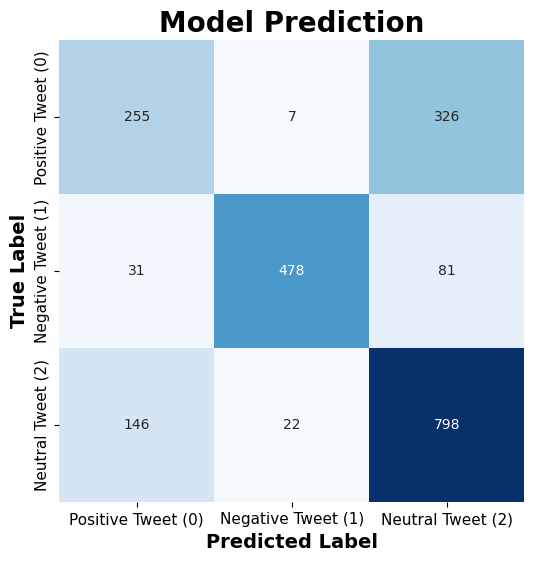

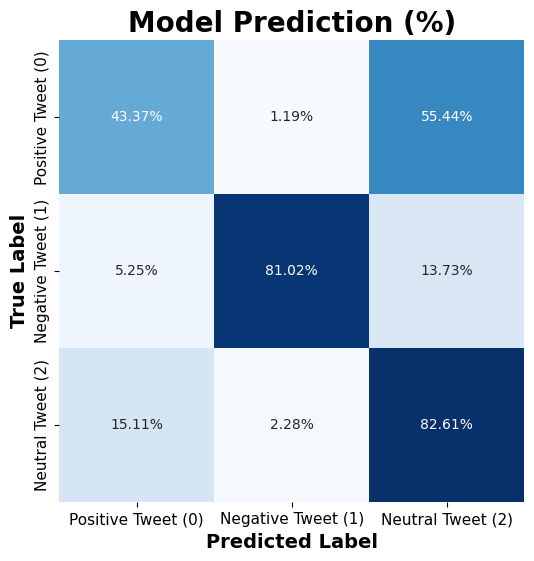

              precision    recall  f1-score   support

           0       0.59      0.43      0.50       588
           1       0.94      0.81      0.87       590
           2       0.66      0.83      0.74       966

    accuracy                           0.71      2144
   macro avg       0.73      0.69      0.70      2144
weighted avg       0.72      0.71      0.71      2144

Accuracy: 0.7140858208955224


In [19]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    if normalize:
        cm_df = cm_df.div(cm_df.sum(axis=1), axis=0)

    fig, ax = plt.subplots(figsize=(6, 6))

    sns.heatmap(cm_df, annot=True, fmt=".2%" if normalize else "d", cmap='Blues', ax=ax, cbar=False)

    ax.set_title('Model Prediction' + (' (%)' if normalize else ''), fontsize=20, weight='bold')
    ax.set_xlabel('Predicted Label', fontsize=14, weight='bold')
    ax.set_ylabel('True Label', fontsize=14, weight='bold')

    # Define the labels
    labels = ['Positive Tweet (0)', 'Negative Tweet (1)', 'Neutral Tweet (2)']

    # Set the tick labels with increased size
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_yticklabels(labels, fontsize=11)

    plt.show()

# Set classes
classes = [0, 1, 2]

# Plot the non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes)

# Plot the normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Test Precision (micro): 0.7140858208955224
Train Precision (micro): 0.7847481343283582
Test Precision (macro): 0.7317730768776093
Train Precision (macro): 0.804721994215635
Test Precision (weighted): 0.7197109515598735
Train Precision (weighted): 0.790906109889867


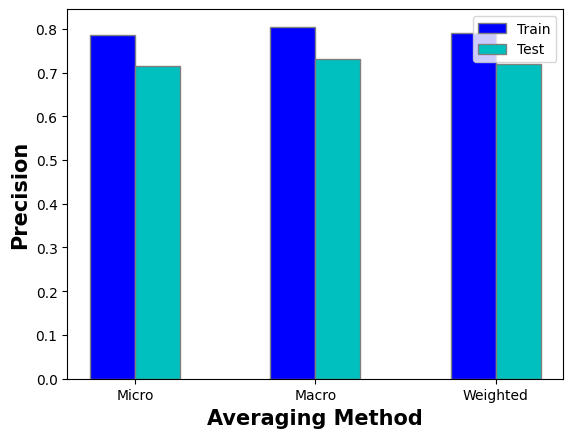

In [20]:
# Train the model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# Calculate precision
precision_test_micro = precision_score(y_test, y_pred_test, average='micro')
precision_train_micro = precision_score(y_train, y_pred_train, average='micro')

precision_test_macro = precision_score(y_test, y_pred_test, average='macro')
precision_train_macro = precision_score(y_train, y_pred_train, average='macro')

precision_test_weighted = precision_score(y_test, y_pred_test, average='weighted')
precision_train_weighted = precision_score(y_train, y_pred_train, average='weighted')

# Print precision
print("Test Precision (micro):", precision_test_micro)
print("Train Precision (micro):", precision_train_micro)
print("Test Precision (macro):", precision_test_macro)
print("Train Precision (macro):", precision_train_macro)
print("Test Precision (weighted):", precision_test_weighted)
print("Train Precision (weighted):", precision_train_weighted)

# Plot precision
bar_width = 0.25
r1 = np.arange(3)
r2 = [x + bar_width for x in r1]

plt.bar(r1, [precision_train_micro, precision_train_macro, precision_train_weighted], color='b', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, [precision_test_micro, precision_test_macro, precision_test_weighted], color='c', width=bar_width, edgecolor='grey', label='Test')

# Adding xticks
plt.xlabel('Averaging Method', fontweight='bold', fontsize=15)
plt.ylabel('Precision', fontweight='bold', fontsize=15)
plt.xticks([r + bar_width/2 for r in range(3)], ['Micro', 'Macro', 'Weighted'])
plt.legend()

plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


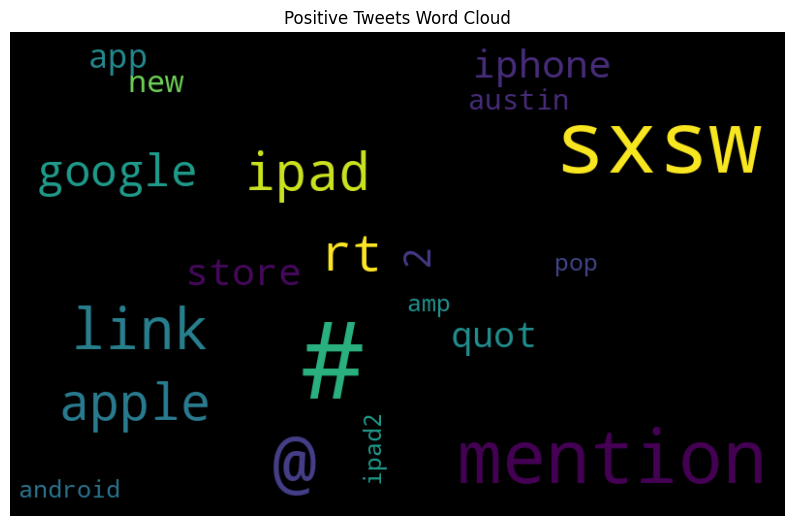

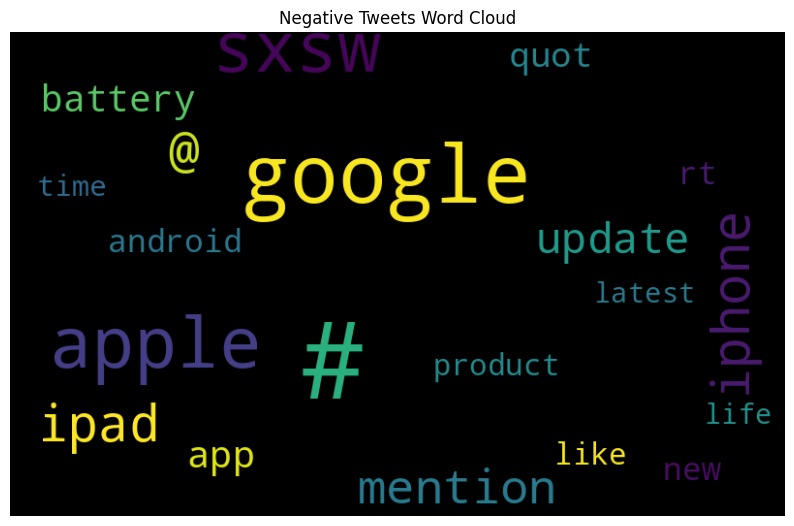

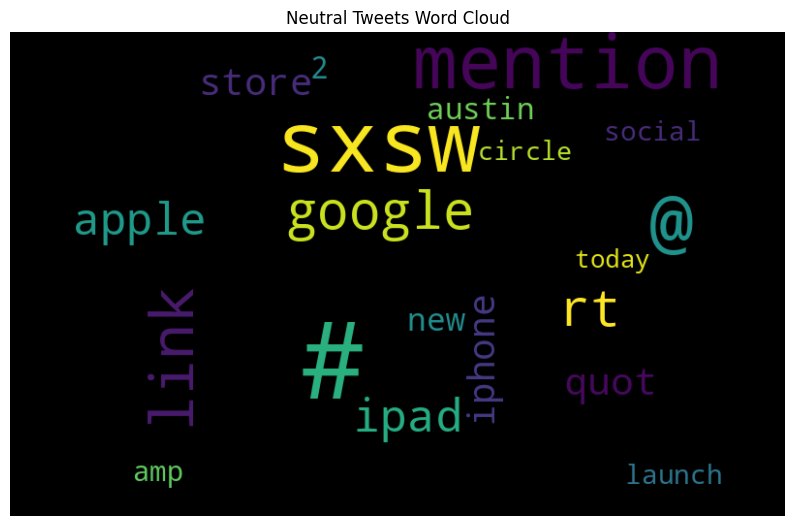

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Separate tweets by class
positive_tweets = df[df['is_tweet_negative'] == 0]['processed_tweet']
negative_tweets = df[df['is_tweet_negative'] == 1]['processed_tweet']
neutral_tweets = df[df['is_tweet_negative'] == 2]['processed_tweet']

# Join the different processed titles together.
positive_words = ' '.join(positive_tweets)
negative_words = ' '.join(negative_tweets)
neutral_words = ' '.join(neutral_tweets)

# Tokenize the words and count the frequency
positive_word_freq = Counter(word_tokenize(positive_words))
negative_word_freq = Counter(word_tokenize(negative_words))
neutral_word_freq = Counter(word_tokenize(neutral_words))

# Select top 20 most frequent words for each class
positive_most_common = dict(positive_word_freq.most_common(20))
negative_most_common = dict(negative_word_freq.most_common(20))
neutral_most_common = dict(neutral_word_freq.most_common(20))

# Create word clouds
wordcloud_positive = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(positive_most_common)
wordcloud_negative = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(negative_most_common)
wordcloud_neutral = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(neutral_most_common)

# Plot word clouds
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Tweets Word Cloud')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Tweets Word Cloud')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis('off')
plt.title('Neutral Tweets Word Cloud')
plt.show()


## Model 2

In [22]:
df.head()

,tweet,tweet_is_directed_at,emotion,character_count,word_count,is_tweet_negative,is_apple,number_of_mentions,hashtags_count,average_word_length,chatgpt_data,processed_tweet
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iphone,negative,127,23,1,1,1,2,4.521739,0,@wesley83 3g iphone 3 hr tweeting #rise_austin...
1,@jessedee know about @fludapp ? awesome ipad/i...,ipad or iphone app,positive,139,22,0,1,2,1,5.363636,0,@jessedee know @fludapp awesome ipad iphone ap...
2,@swonderlin can not wait for #ipad 2 also. the...,ipad,positive,79,15,0,1,1,2,4.333333,0,@swonderlin wait #ipad 2 also sale #sxsw
3,@sxsw i hope this year's festival isn't as cra...,ipad or iphone app,negative,82,15,1,1,1,1,4.533333,0,@sxsw hope year festival crashy year iphone ap...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,google,positive,131,17,0,0,1,1,6.764706,0,@sxtxstate great stuff fri #sxsw marissa mayer...


In [23]:
# Function to fit model and print classification report.
def model_tester(model, X_train=X_train, y_train=y_train):
    model.fit(X_train, y_train)
    print(classification_report(y_test, model.predict(X_test)))


In [24]:
# Function to perform grid search and print classification report for best parameters.
def model_best_param_tester(model, params, X_train=X_train, y_train=y_train):
    gridsearch=GridSearchCV(model, param_grid=params)
    gridsearch.fit(X_train, y_train)
    print(gridsearch.best_params_)
    return model_tester(gridsearch.best_estimator_)

In [25]:
#Initializing the models we will test out.
logreg=LogisticRegression()
bayes=MultinomialNB()
dtc=DecisionTreeClassifier()
rfc=RandomForestClassifier()
xg=xgb.XGBClassifier()

In [26]:
#model_best_param_tester(logreg, {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear', 'newton-cg']})


In [27]:
#model_best_param_tester(bayes, {'fit_prior': [True, False], 'alpha': [0.001, 0.01, 0.1, 1]})


In [28]:
#model_best_param_tester(dtc, {'max_depth': [1,2,3,4,5], 'max_features': [1,2,3,4]})


In [29]:
#model_best_param_tester(rfc, {'n_estimators': [100, 150], 'max_features': [1,'sqrt', 'log2'], 'criterion': ['gini', 'entropy']})


In [30]:
#model_best_param_tester(xg, {'booster': ['gbtree', 'gblinear' 'dart']})


The Gradient Boosting Classifier with default parameters has the best performance of all the models examined.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer=CountVectorizer()
apple_vectorized=count_vectorizer.fit_transform(df.loc[(df['is_tweet_negative']==1) & (df['is_apple']==1)]['processed_tweet'])
apple_data=pd.DataFrame(data=apple_vectorized.toarray(), columns=count_vectorizer.get_feature_names_out())
text=''
for a in apple_data.sum().sort_values(ascending=False)[:20].index:
    text=text+a+' '
text
WordCloud().generate(text)

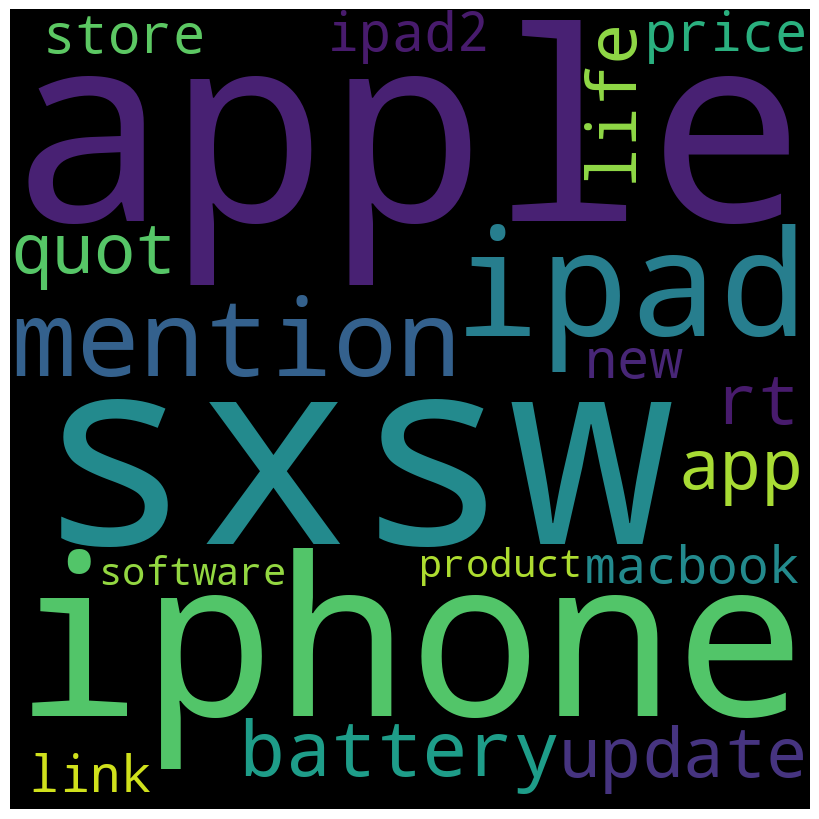

In [32]:

# Your existing code
count_vectorizer = CountVectorizer()
apple_vectorized = count_vectorizer.fit_transform(df.loc[(df['is_tweet_negative'] == 1) & (df['is_apple'] == 1)]['processed_tweet'])
apple_data = pd.DataFrame(data = apple_vectorized.toarray(), columns = count_vectorizer.get_feature_names_out())

text = ''
for a in apple_data.sum().sort_values(ascending = False)[:20].index:
    text = text + a + ' '

# Generate WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = None,
                min_font_size = 10).generate(text)

# Plot WordCloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
